In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import Model,Parameters
import lmfit

df = pd.read_excel('COVID-19-geographic-disbtribution-worldwide(1).xlsx') # Taken from https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
df['dateRep'] = pd.to_datetime(df['dateRep'])

country_code = 'GBR'
ix = df['countryterritoryCode'] == country_code

df2 = df[ix]

df2.sort_values(by='dateRep',ascending=True,inplace=True)

date_of_first_death = df2[df2['deaths']>0]['dateRep'].min()
ix_of_first_death = np.where(df2['dateRep']==date_of_first_death)[0][0]
date_of_first_case = df2[df2['cases']>0]['dateRep'].min()
ix_of_first_case = np.where(df2['dateRep']==date_of_first_case)[0][0]

# Trim data to 10 days before the first case
days_before_first_death = 10
df2 = df2.iloc[(ix_of_first_death-days_before_first_death):]
t_domain = (df2["dateRep"]-df2["dateRep"].iloc[0]).dt.days
t=t_domain.values

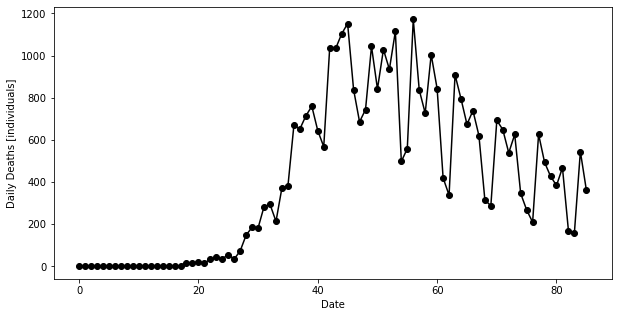

In [36]:
plt.figure(figsize=(10,5))
plt.plot(t, df2['deaths'], '-ok')
plt.xlabel('Date')
plt.ylabel('Daily Deaths [individuals]')
plt.show()

# Construct the equations

In [37]:
def SIRD(t, y, b, g, m):

    S = y[0]
    I = y[1]

    # I = y[1], S = y[0], R = y[2]

    dS = -b * I * S
    dI = (b * I * S) - (g * I) - (m * I)
    dR = g * I # actually redundant to calculate
    dD = m * I

    return [dS, dI, dD]

def SIRD_daily_deaths(t, b, g, m, s0, i0):
    y0 = [s0-i0, i0, 0]
    Y = solve_ivp(lambda t, y: SIRD(t, y, b, g, m), [t[0], t[-1]], y0, t_eval=t)
    g = np.gradient(Y.y[2,:], Y.t)

    if Y.y.shape[1] != t.size:
        return np.zeros(t.size)
    else:
        return g

# Test it

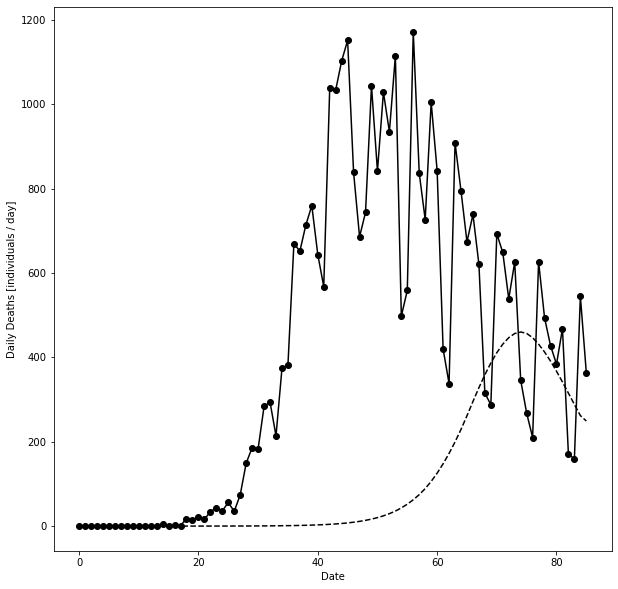

In [38]:
b = 1e-8
g = 0.3
m = 0.0001
s0 = df2['popData2018'].iloc[0]*0.75
i0 = 10

death_rate = SIRD_daily_deaths(t, b, g, m, s0, i0)

plt.figure(figsize=(10,10))
plt.plot(t, df2['deaths'], '-ok')
plt.plot(t, death_rate, '--k')
plt.xlabel('Date')
plt.ylabel('Daily Deaths [individuals / day]')
plt.show()

# Solve using LMFit

In [39]:
gmodel = Model(SIRD_daily_deaths)
params = Parameters()
params.add('b', value=1e-8, vary=True)
params.add('g', value=0.15, max=1, vary=True)
params.add('m', value=0.0001, min=1e-5, max=0.1, vary=True)
params.add('s0', value=(df2['popData2018'].iloc[0]), vary=False)
params.add('i0', value=10, min=1, max=10000, vary=True)

result = gmodel.fit(df2["deaths"], params,t=t, verbose=1)

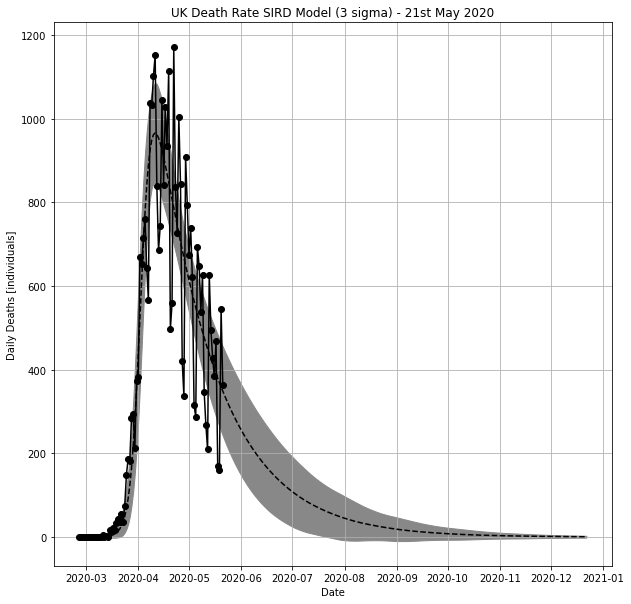

In [40]:
tt = np.linspace(0, 300, 301)
ttt=pd.date_range(start=df2["dateRep"].iloc[0],periods=301)
pred = result.eval(t=tt)
uncertainties = result.eval_uncertainty(sigma=3, t = tt, verbose=True)

plt.figure(figsize=(10,10))
plt.plot(ttt, pred, '--k')
plt.plot(df2['dateRep'], df2['deaths'], '-ok')
plt.fill_between(ttt, pred-uncertainties, pred+uncertainties, color='#888888')
plt.xlabel('Date')
plt.ylabel('Daily Deaths [individuals]')
plt.title('UK Death Rate SIRD Model (3 sigma) - 21st May 2020')
plt.grid(True)
plt.show()

# CDF

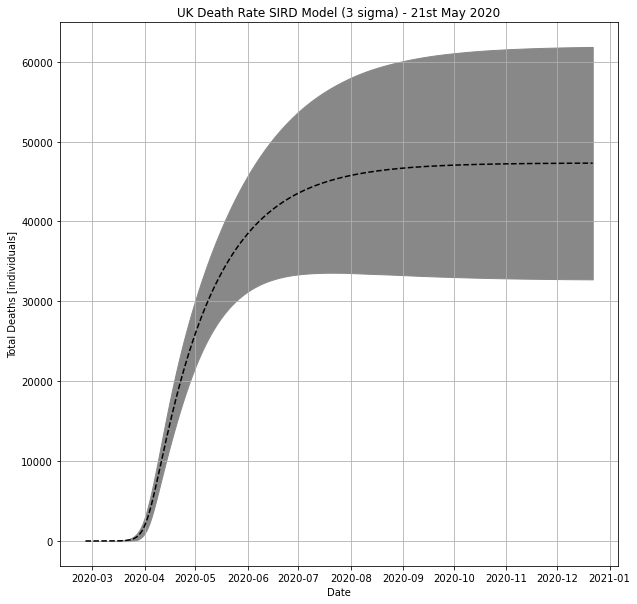

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(ttt, np.cumsum(pred), '--k')
#plt.plot(ttt, np.cumsum(pred-uncertainties)/np.sum(pred-uncertainties))
#plt.plot(ttt, np.cumsum(pred+uncertainties)/np.sum(pred+uncertainties))
plt.fill_between(ttt, np.cumsum(pred-uncertainties), np.cumsum(pred+uncertainties), color='#888888')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cumulative Deaths [individuals]')
plt.title('UK Death Rate SIRD Model (3 sigma) - 21st May 2020')
plt.show()